In [9]:
import os
import json

json_data = json.load(open('env.json'))  # this or specify manually
os.environ['AWS_DEFAULT_REGION'] = json_data['AWS_DEFAULT_REGION']
os.environ['AWS_REGION'] = json_data['AWS_REGION']
os.environ['AWS_ACCESS_KEY_ID'] = json_data['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = json_data['AWS_SECRET_ACCESS_KEY']
os.environ['MLFLOW_S3_ENDPOINT_URL'] = json_data['MLFLOW_S3_ENDPOINT_URL']
os.environ['MLFLOW_TRACKING_URI'] = json_data['MLFLOW_TRACKING_URI']


from mlflow import MlflowClient

import mlflow.pytorch
import mlflow.keras
import mlflow
from mlflow.models import infer_signature

import matplotlib.pyplot as plt

import torch

import numpy as np
import pandas as pd

mlflow.set_experiment(
    'my-experiment'
)  # change the name of the experiment to your liking


# some data for us to play with
data_X = np.random.uniform(-1, 1, (1000, 2))
data_y = np.max(data_X, axis=1)

2025/03/14 16:44:50 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 
/home/gbm96348/nfs_home/ml_env/lib/python3.11/site-packages/mlflow/pyfunc/__init__.py:2226: UserWarning: The `code_path` argument is replaced by `code_paths` and is deprecated as of MLflow version 2.12.0. This argument will be removed in a future release of MLflow.
  warnings.warn(
2025/03/14 16:44:57 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-04-16; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'lume-model'}
2025/03/14 16:44:57 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - paho

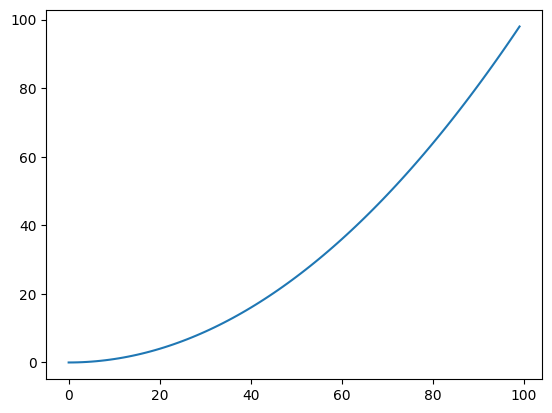

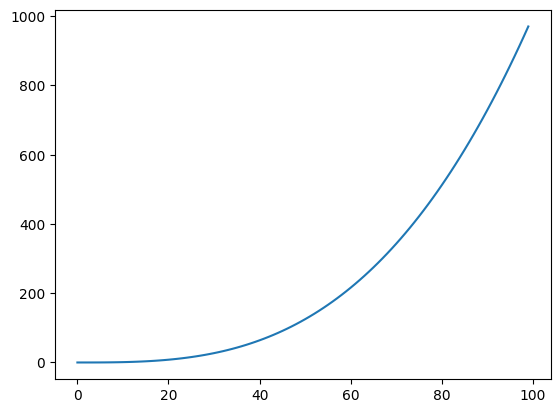

In [10]:
### Torch GENERIC MODEL EXAMPLE

from model_definition import ExampleModel
from lume_model.variables import ScalarInputVariable, ScalarOutputVariable


# basic wrapper we use to take advantage of mlflow logging
class MyModel(mlflow.pyfunc.PythonModel):
    def __init__(self, model_name, model):
        self.model_name = model_name
        self.model = model

    def predict(self, context, input, **kwargs):
        return self.model.evaluate(input)

    def save_model(self):
        with open(f'{self.model_name}.txt', 'w') as f:
            f.write('model saved')

    def load_model(self):
        with open(f'{self.model_name}.txt', 'r') as f:
            return f.read()

    def get_lume_model(self):  # define this function to get deployment to work
        return self.model


# lume-model example, we need to define it in a separate file and import it due to jupyternotebook namespace issues

####################################################### MODEL DEFINITION ########################################################
#
# from lume_model.base import LUMEBaseModel
#
# import numpy as np
#
# class ExampleModel(LUMEBaseModel):
#     def evaluate(self, input_dict):
#         output_dict = {}
#         output_dict["y"] = np.max([input_dict["x1"], input_dict["x2"]])
#         return output_dict
#
#
##################################################################################################################################

input_variables = [
    ScalarInputVariable(name='x1', default=0, value_range=[-100000, 1000000]),
    ScalarInputVariable(name='x2', default=0, value_range=[-100000, 1000000]),
]
output_variables = [ScalarOutputVariable(name='y')]
lume_model = ExampleModel(
    input_variables=input_variables, output_variables=output_variables
)
model = MyModel('model1', lume_model)

input_sample = pd.DataFrame(data_X, columns=['x1', 'x2'])

with (
    mlflow.start_run() as run
):  # you can use run_name="test1" to give a name to the run otherwise it will a random name
    # set some tags for the experiment
    mlflow.set_tag('exp_tag1', 'exp_tag_value1')
    mlflow.set_tag('exp_tag2', 'exp_tag_value2')
    mlflow.set_tag('exp_tag3', 'exp_tag_value3')

    # model.save_model() # no need to save the model since it is saved in log_model
    mlflow.log_param('model_name', model.model_name)
    mlflow.log_param('dummy_param1', 'dummy_value1')
    mlflow.log_param('dummy_param2', 0.33)
    for i in range(10):
        mlflow.log_metric('metric1', (i / 10) ** 2, step=i)
        mlflow.log_metric('metric2', (i / 10) ** 3, step=i)
        mlflow.log_metric('loss', (1 / (i + 0.1) + np.random.normal(0, 0.1)), step=i)

    # lets make some pretty graphs to store

    graph = plt.figure()
    plt.plot(range(100), [(i / 10) ** 2 for i in range(100)])
    mlflow.log_figure(graph, 'figures/metric1.png')

    # alternative way to log a figure
    graph = plt.figure()
    plt.plot(range(100), [(i / 10) ** 3 for i in range(100)])
    graph.savefig('metric2.png')
    mlflow.log_artifact('metric2.png', artifact_path='figures')

    model_info = mlflow.pyfunc.log_model(
        artifact_path='model_files',
        python_model=model,
        signature=infer_signature(
            input_sample, model.predict(None, input=input_sample)
        ),
        input_example=input_sample,
        code_path=['model_definition.py'],
        extra_pip_requirements=['paho-mqtt'],  # example dependancy
        # registered_model_name="generic_model", # this will automatically register the model and iterate the version
    )

    # if you wanna log the model without the wrapper
    model.save_model()
    mlflow.log_artifact(
        f'{model.model_name}.txt', artifact_path='model_files_no_mlflow'
    )
    mlflow.log_artifact('./generic/pv_mapping.yaml', artifact_path='generic_model')

In [11]:
# we ignore keras for now
# # keras model

# inputs = [keras.Input(name="input1", shape=(1,)), keras.Input(name="input2", shape=(1,))]
# x = keras.layers.concatenate(inputs)
# x1 = keras.layers.Dense(64, activation='relu')(x)
# x2 = keras.layers.Dense(64, activation='relu')(x1)
# outputs = keras.layers.Dense(1, name="output")(x2)
# model_keras = keras.Model(inputs=inputs, outputs=outputs)

# mlflow.keras.autolog(log_models=False)
# with mlflow.start_run() as run:
#     model_keras.compile(optimizer='adam', loss='mean_squared_error')
#     model_keras.fit([data_X[:, 0], data_X[:, 1]], data_y, epochs=10)
#     mlflow.set_tag("tag1", "tag_value1")
#     signature = infer_signature(data_X, model_keras.predict([data_X[:, 0], data_X[:, 1]]))
#     model_info_keras = mlflow.keras.log_model(model_keras, "keras_model", signature=signature)

In [12]:
from typing import Any

# from lume_model.models import TorchModel, TorchModule
import logging

# torch model
base_torch = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

# change initialisation
for layer in base_torch:
    if isinstance(layer, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
        torch.nn.init.zeros_(layer.bias)
        layer.weight.data.fill_(0.05)
        layer.bias.data.fill_(0.05)


mlflow.pytorch.autolog()


class MyModel(mlflow.pyfunc.PythonModel):
    def __init__(self, model_name, model):
        self.model_name = model_name
        self.model = model

    def predict(self, context, input, **kwargs):
        return self.model.evaluate(input)

    def save_model(self):
        with open(f'{self.model_name}.txt', 'w') as f:
            f.write('model saved')

    def load_model(self):
        with open(f'{self.model_name}.txt', 'r') as f:
            return f.read()

    def get_lume_model(self):  # define this function to get deployment to work
        return self.model


class TorchModel:
    def __init__(self, model):
        self.model = model

    def forward(self, x):
        return self.model(x)

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        return self.model(*args, **kwds)

    def evaluate(self, input_dict):
        # make my dict to tensor
        logging.debug(f'input_dict: {input_dict}')

        input = torch.tensor(
            [[input_dict['x1'], input_dict['x2']]], dtype=torch.float32
        )

        # do some clipping etc
        input = torch.clip(input, -1, 1)

        output_dict = {}
        output_dict['y'] = self.model(input).detach().numpy()[0][0]

        return output_dict


with mlflow.start_run() as run:
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(base_torch.parameters(), lr=0.01)
    # log params
    mlflow.log_param('lr', 0.01)
    mlflow.log_param('optimizer', 'Adam')
    mlflow.log_param('loss', 'MSELoss')

    for t in range(20):
        X = torch.tensor(data_X, dtype=torch.float32)
        y = torch.tensor(data_y, dtype=torch.float32)
        y_pred = base_torch(X).flatten()
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mlflow.log_metric('loss', np.mean(loss.detach().numpy()), step=t)
        print(t, np.mean(loss.detach().numpy()))

    mlflow.set_tag('tag1', 'tag_value1')

    # lume_torch = TorchModel(model = base_torch, input_variables = input_variables, output_variables = output_variables)

    # model_torch = TorchModule(model = lume_torch)

    ## lets do this without lume model

    model_torch = TorchModel(model=base_torch)

    mlflow.log_artifact('torch/pv_mapping.yaml', artifact_path='torch_model')

    signature = infer_signature(
        data_X, model_torch(torch.tensor(data_X, dtype=torch.float32)).detach().numpy()
    )  # optional but useful

    # model_info_torch = mlflow.pytorch.log_model(model_torch, "torch_model", signature=signature)
    # log generic model
    model_torch = MyModel('torch_model', model_torch)

    model_info_torch = mlflow.pyfunc.log_model(
        artifact_path='torch_model',
        python_model=model_torch,
        signature=signature,
        input_example=pd.DataFrame(data_X, columns=['x1', 'x2']),
        code_path=['model_definition.py'],
        extra_pip_requirements=['paho-mqtt'],  # example dependancy
        # registered_model_name="generic_model", # this will automatically register the model and iterate the version
    )

2025/03/14 16:44:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.


0 0.22179449
1 0.11248085
2 0.14646377
3 0.17016892
4 0.17291665
5 0.1591252
6 0.13465571
7 0.10968375
8 0.1004689
9 0.11623836
10 0.13164918
11 0.120537326
12 0.10016023
13 0.0916404
14 0.095433205
15 0.101972
16 0.10483998
17 0.100982055
18 0.09255473
19 0.085351616


/home/gbm96348/nfs_home/ml_env/lib/python3.11/site-packages/mlflow/pyfunc/__init__.py:2226: UserWarning: The `code_path` argument is replaced by `code_paths` and is deprecated as of MLflow version 2.12.0. This argument will be removed in a future release of MLflow.
  warnings.warn(
2025/03/14 16:45:24 WARNING mlflow.utils.requirements_utils: Failed to run predict on input_example, dependencies introduced in predict are not captured.
RuntimeError('mat1 and mat2 shapes cannot be multiplied (2x1000 and 2x64)')Traceback (most recent call last):


  File "/home/gbm96348/nfs_home/ml_env/lib/python3.11/site-packages/mlflow/utils/_capture_modules.py", line 135, in _load_pyfunc_patch
    model.predict(input_example, params=params)


  File "/home/gbm96348/nfs_home/ml_env/lib/python3.11/site-packages/mlflow/pyfunc/model.py", line 547, in predict
    return self.python_model.predict(self.context, self._convert_input(model_input))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [13]:
# specifc model uris
print(model_info.model_uri)
# print(model_info_keras.model_uri)
print(model_info_torch.model_uri)

# lets register the models if they are not already this step is necessary for deployment
client = MlflowClient()
try:
    client.create_registered_model('generic_model')

except:
    pass

# try:
#     client.create_registered_model("keras_model")
# except:
#     pass

try:
    client.create_registered_model('torch_model')
except:
    pass

# create new model versions

# str(dict_model)
result_generic = client.create_model_version(
    name='generic_model',
    source=model_info.model_uri,
    run_id=model_info.run_id,
    tags={'tests': 'pending', 'framework': 'pyfunc'},
)


# result_keras = client.create_model_version(
#     name="keras_model",
#     source=model_info_keras.model_uri,
#     run_id=model_info_keras.run_id,
# )


result_torch = client.create_model_version(
    name='torch_model',
    source=model_info_torch.model_uri,
    run_id=model_info_torch.run_id,
)

client.set_registered_model_alias('generic_model', 'challenger', result_generic.version)


client.set_registered_model_tag('generic_model', 'deployment_publish', 'false')
client.set_registered_model_tag('generic_model', 'deployment_type', 'continuous')


# do some tests
model_ver_champ = client.get_model_version_by_alias(
    'generic_model', 'challenger'
).version

# 99% of the time it will pass
if np.random.uniform() < 0.99:
    client.set_model_version_tag(
        'generic_model', f'{model_ver_champ}', 'tests', 'passed'
    )
    # set the champion model
    client.set_registered_model_alias(
        'generic_model', 'champion', result_generic.version
    )
else:
    client.set_model_version_tag(
        'generic_model', f'{model_ver_champ}', 'tests', 'failed'
    )
    print('model failed')

# client.set_registered_model_alias("keras_model", "champion", result_keras.version)
# # client.set_registered_model_tag("keras_model", "lattice_component", "DEF")
# # client.set_registered_model_tag("keras_model", "lume_service", "false")
# # client.set_registered_model_tag("keras_model", "lume_service_url", "")
# # client.set_registered_model_tag("keras_model", "deployment_type", "continuous")
# # client.set_registered_model_tag("keras_model", "multi_model_service", "false")
# # client.set_registered_model_tag("keras_model", "retrain", "false")
# # client.set_registered_model_tag("keras_model", "retrain_endpoint", "")

client.set_registered_model_alias('torch_model', 'champion', result_torch.version)
client.set_registered_model_tag('torch_model', 'deployment_type', 'continuous')

2025/03/14 16:45:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: generic_model, version 19
2025/03/14 16:45:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: torch_model, version 20


runs:/f1272c34290f4ab9bd72477af2c3eb8f/model_files
runs:/da0efc0f56264cd29da3211c3c1d40a4/torch_model


In [14]:
# get model ids from registered models
# genric_model  = mlflow.pyfunc.load_model(f"models:/generic_model@champion")
# keras_model = mlflow.keras.load_model(f"models:/keras_model@champion")
torch_model = mlflow.pyfunc.load_model('models:/torch_model@champion')

# # get model info
# print("Generic model")
# print(genric_model, type(genric_model))
# print("Keras model")
# print(keras_model, type(keras_model)
print('Torch model')
print(torch_model, type(torch_model))

# new_data = np.random.uniform(-1, 1, (20, 2))
# print(new_data)

# lets run some predictions

# print("Generic model")
# print(genric_model.predict(new_data))
# print("Keras model")
# print(keras_model.predict([new_data[:, 0], new_data[:, 1]]))

2025/03/14 16:45:26 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - paho-mqtt (current: uninstalled, required: paho-mqtt)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


Torch model
mlflow.pyfunc.loaded_model:
  artifact_path: torch_model
  flavor: mlflow.pyfunc.model
  run_id: da0efc0f56264cd29da3211c3c1d40a4
 <class 'mlflow.pyfunc.PyFuncModel'>


In [15]:
# extract model
torch_model

mlflow.pyfunc.loaded_model:
  artifact_path: torch_model
  flavor: mlflow.pyfunc.model
  run_id: da0efc0f56264cd29da3211c3c1d40a4

In [16]:
# # cloudpickle generic object instance
# import cloudpickle
# with open("generic_model.pkl", "wb") as f:
#     cloudpickle.dump(genric_model, f)